# K-Nearest Neighbors Regression Model

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# 1. Load the dataset
df = pd.read_excel('data.xlsx', index_col='Date', parse_dates=True)


In [3]:
df.head()

,temperature_2m (°C),relative_humidity_2m (%),wind_speed_10m (km/h),soil_moisture_0_to_7cm (m³/m³),direct_radiation (W/m²),turbidity
Date,,,,,,
2020-12-31 15:00:00,4.0,78,9.8,0.391,55,0.430411
2020-12-31 16:00:00,3.4,85,5.6,0.391,25,0.522836
2020-12-31 17:00:00,1.5,94,7.3,0.390,3,0.512069
2020-12-31 18:00:00,0.8,95,7.1,0.389,0,0.450545
2020-12-31 19:00:00,-0.1,97,8.4,0.388,0,0.405494


In [4]:
df = df.rename(columns={'turbidity': 'y'})

In [5]:
df =df.asfreq('H')

C:\Users\Yin Jianing\AppData\Local\Temp\ipykernel_16932\347257380.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df =df.asfreq('H')


In [6]:
df.index

DatetimeIndex(['2020-12-31 15:00:00', '2020-12-31 16:00:00',
               '2020-12-31 17:00:00', '2020-12-31 18:00:00',
               '2020-12-31 19:00:00', '2020-12-31 20:00:00',
               '2020-12-31 21:00:00', '2020-12-31 22:00:00',
               '2020-12-31 23:00:00', '2021-01-01 00:00:00',
               ...
               '2023-12-30 00:00:00', '2023-12-30 01:00:00',
               '2023-12-30 02:00:00', '2023-12-30 03:00:00',
               '2023-12-30 04:00:00', '2023-12-30 05:00:00',
               '2023-12-30 06:00:00', '2023-12-30 07:00:00',
               '2023-12-30 08:00:00', '2023-12-30 09:00:00'],
              dtype='datetime64[ns]', name='Date', length=26251, freq='h')

In [7]:
df.columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'wind_speed_10m (km/h)', 'soil_moisture_0_to_7cm (m³/m³)',
       'direct_radiation (W/m²)', 'y'],
      dtype='object')

In [8]:
df.dtypes

temperature_2m (°C)               float64
relative_humidity_2m (%)            int64
wind_speed_10m (km/h)             float64
soil_moisture_0_to_7cm (m³/m³)    float64
direct_radiation (W/m²)             int64
y                                 float64
dtype: object

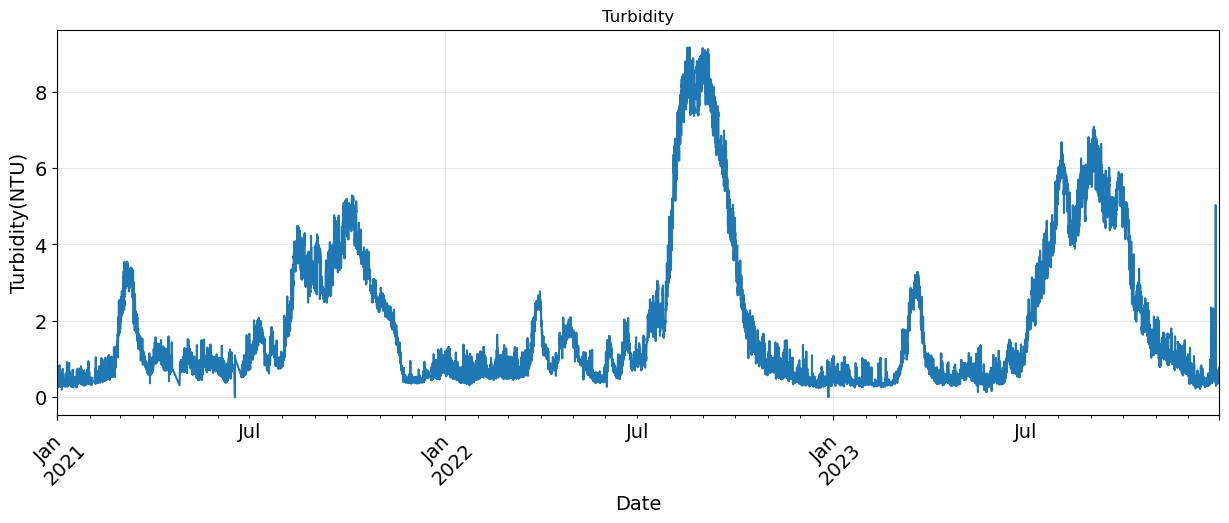

In [12]:
df['y'].plot(figsize=(15, 5), title='Turbidity', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Turbidity(NTU)', fontsize=14)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.show()


In [14]:
# 2. Create lag features for weather variables
df['relative_humidity_2m (%)_lag3'] = df['relative_humidity_2m (%)'].shift(3)
df['wind_speed_10m (km/h)_lag3'] = df['wind_speed_10m (km/h)'].shift(3)
df['soil_moisture_0_to_7cm (m³/m³)_lag72'] = df['soil_moisture_0_to_7cm (m³/m³)'].shift(72)
df['direct_radiation (W/m²)_lag72'] = df['direct_radiation (W/m²)'].shift(72)

In [15]:
df = df.dropna()  
df

,temperature_2m (°C),relative_humidity_2m (%),wind_speed_10m (km/h),soil_moisture_0_to_7cm (m³/m³),direct_radiation (W/m²),y,relative_humidity_2m (%)_lag3,wind_speed_10m (km/h)_lag3,soil_moisture_0_to_7cm (m³/m³)_lag72,direct_radiation (W/m²)_lag72
Date,,,,,,,,,,
2021-01-03 15:00:00,3.6,80,17.2,0.378,31,0.367532,85.0,15.3,0.391,55.0
2021-01-03 16:00:00,3.5,78,16.1,0.377,2,0.439294,80.0,17.9,0.391,25.0
2021-01-03 17:00:00,3.0,77,14.5,0.377,2,0.445193,78.0,19.9,0.390,3.0
2021-01-03 18:00:00,2.7,81,14.9,0.376,0,0.371390,80.0,17.2,0.389,0.0
2021-01-03 19:00:00,2.5,82,16.5,0.376,0,0.366914,78.0,16.1,0.388,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-30 05:00:00,6.9,90,21.5,0.399,0,0.455236,87.0,22.9,0.397,0.0
2023-12-30 06:00:00,6.9,90,21.4,0.399,0,0.398240,88.0,21.1,0.404,0.0
2023-12-30 07:00:00,6.7,91,19.0,0.398,0,0.413984,88.0,21.8,0.408,0.0


In [16]:
# 3. Define features (X) and target (y)
X = df.drop(columns=['y'])
y = df['y']

In [17]:
# 4. Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Train-test split (70% train, 15% val, 15% test, maintaining time order)
n_total = len(df)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)
n_test = n_total - n_train - n_val

X_train, y_train = X_scaled[:n_train], y[:n_train]
X_val, y_val = X_scaled[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X_scaled[n_train+n_val:], y[n_train+n_val:]





In [19]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [70]:
# Hyperparameter tuning for KNN
param_grid = {
    'n_neighbors': np.arange(1, 21),
    'leaf_size': [30, 40, 50] }

knn = KNeighborsRegressor()

In [71]:
grid_search = GridSearchCV(knn, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'leaf_size': [30, 40, 50],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='neg_mean_absolute_error')

In [72]:
# Best model
best_knn = grid_search.best_estimator_


In [73]:
# Evaluate on validation set
val_pred = best_knn.predict(X_val)
print("Validation MAE:", mean_absolute_error(y_val, val_pred))
print("Validation RMSE:", root_mean_squared_error(y_val, val_pred))
print("Validation R²:", r2_score(y_val, val_pred))
print("Validation MAPE:", mean_absolute_percentage_error(y_val, val_pred))
print("Validation MSE:", mean_squared_error(y_val, val_pred))


Validation MAE: 1.3438142512192273
Validation RMSE: 1.750622161880718
Validation R²: -3.3008854224195154
Validation MAPE: 2.1282547066701114
Validation MSE: 3.064677953667919


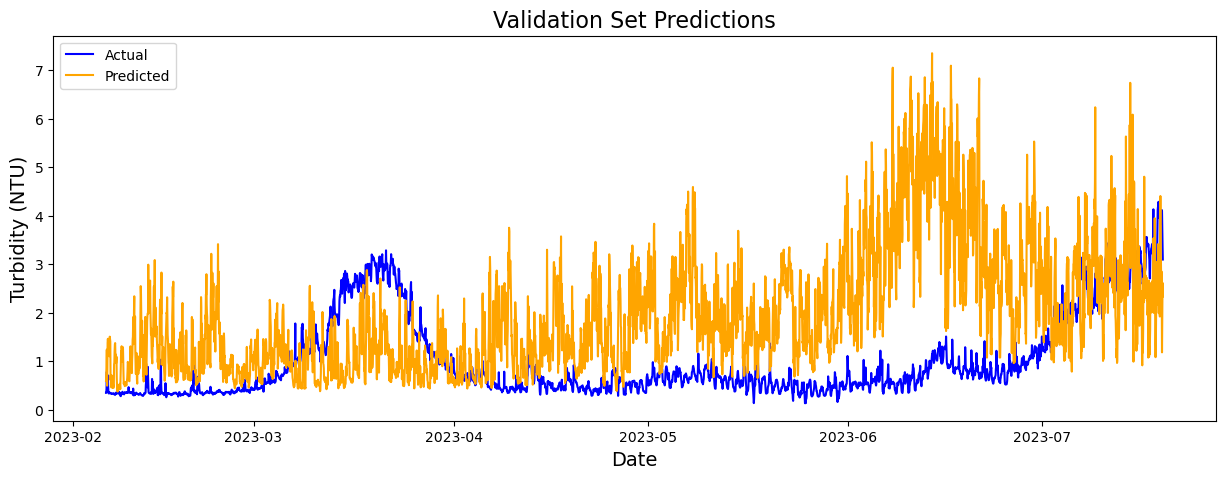

In [74]:
# Plot validation predictions
plt.figure(figsize=(15, 5))
plt.plot(y_val.index, y_val, label='Actual', color='blue')
plt.plot(y_val.index, val_pred, label='Predicted', color='orange')
plt.title('Validation Set Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Turbidity (NTU)', fontsize=14)
plt.legend()
plt.show()

In [75]:
# Final evaluation on test set
test_pred = best_knn.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, test_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))
print("Test R²:", r2_score(y_test, test_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, test_pred))
print("Test MSE:", mean_squared_error(y_test, test_pred))



Test MAE: 1.5349954672437978
Test RMSE: 2.0346818337992016
Test R²: 0.06475790277068416
Test MAPE: 0.4979672818735255
Test MSE: 4.139930164792482


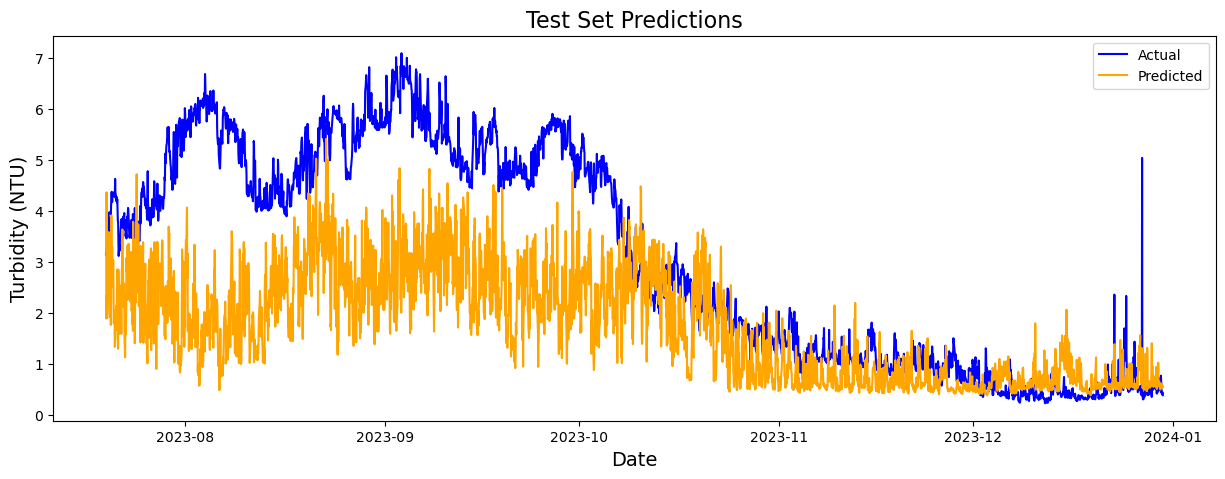

In [77]:
# Plot test predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, test_pred, label='Predicted', color='orange')
plt.title('Test Set Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Turbidity (NTU)', fontsize=14)
plt.legend()
plt.show()

In [78]:
train_pred = best_knn.predict(X_train)
print("Train MAE:", mean_absolute_error(y_train, train_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Train R²:", r2_score(y_train, train_pred))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_pred))
print("Train MSE:", mean_squared_error(y_train, train_pred))


Train MAE: 0.9012481998022129
Train RMSE: 1.3764852173953
Train R²: 0.4755413693234899
Train MAPE: 1063119484801.4792
Train MSE: 1.8947115537077859


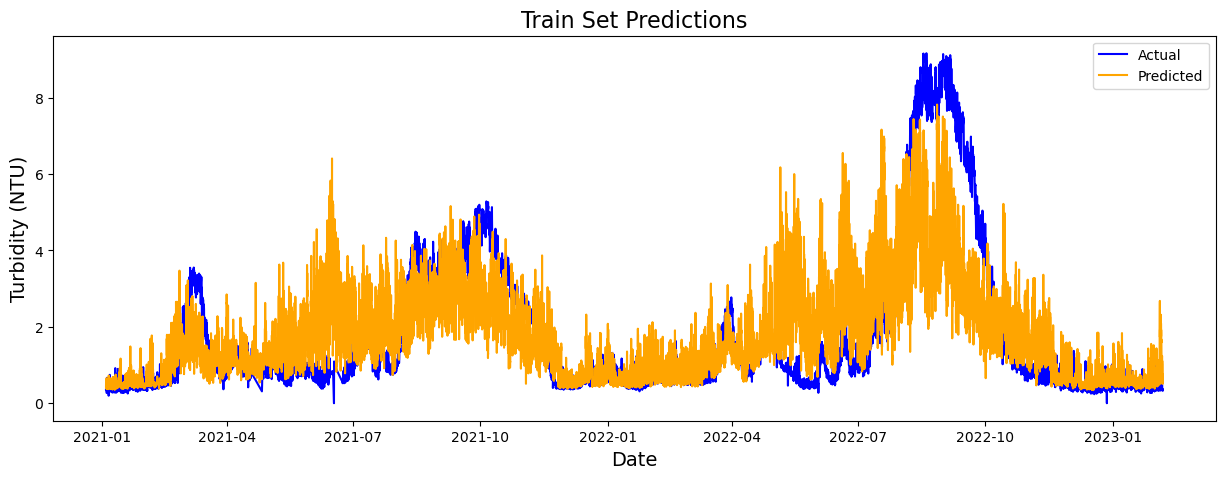

In [79]:
# Plot train predictions
plt.figure(figsize=(15, 5))
plt.plot(y_train.index, y_train, label='Actual', color='blue')
plt.plot(y_train.index, train_pred, label='Predicted', color='orange')
plt.title('Train Set Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Turbidity (NTU)', fontsize=14)
plt.legend()
plt.show()


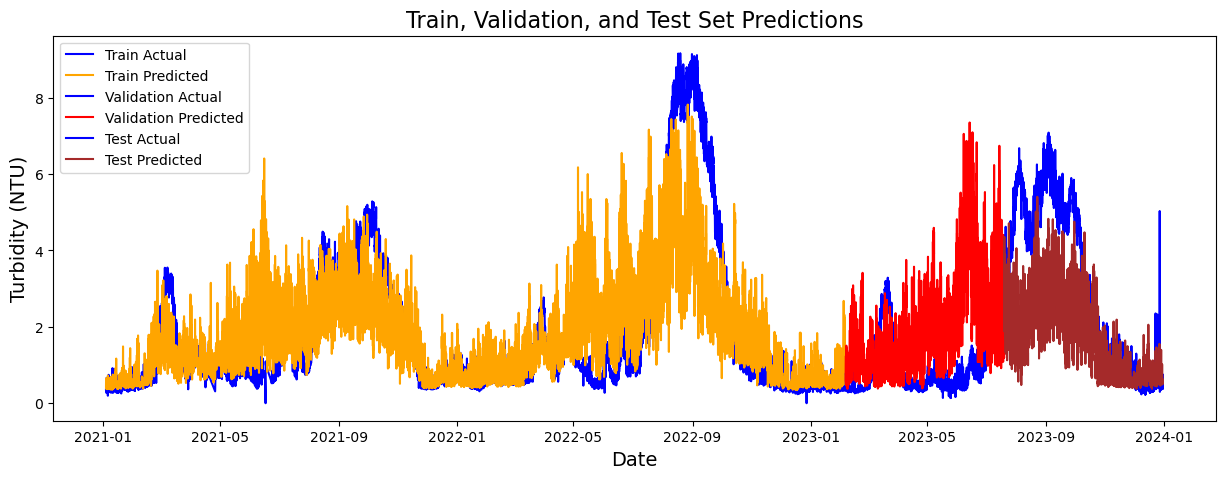

In [80]:
# Plot train, validation, and test predictions together
plt.figure(figsize=(15, 5))
plt.plot(y_train.index, y_train, label='Train Actual', color='blue')
plt.plot(y_train.index, train_pred, label='Train Predicted', color='orange')
plt.plot(y_val.index, y_val, label='Validation Actual', color='blue')
plt.plot(y_val.index, val_pred, label='Validation Predicted', color='red')
plt.plot(y_test.index, y_test, label='Test Actual', color='blue')
plt.plot(y_test.index, test_pred, label='Test Predicted', color='brown')
plt.title('Train, Validation, and Test Set Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Turbidity (NTU)', fontsize=14)
plt.legend()
plt.show()


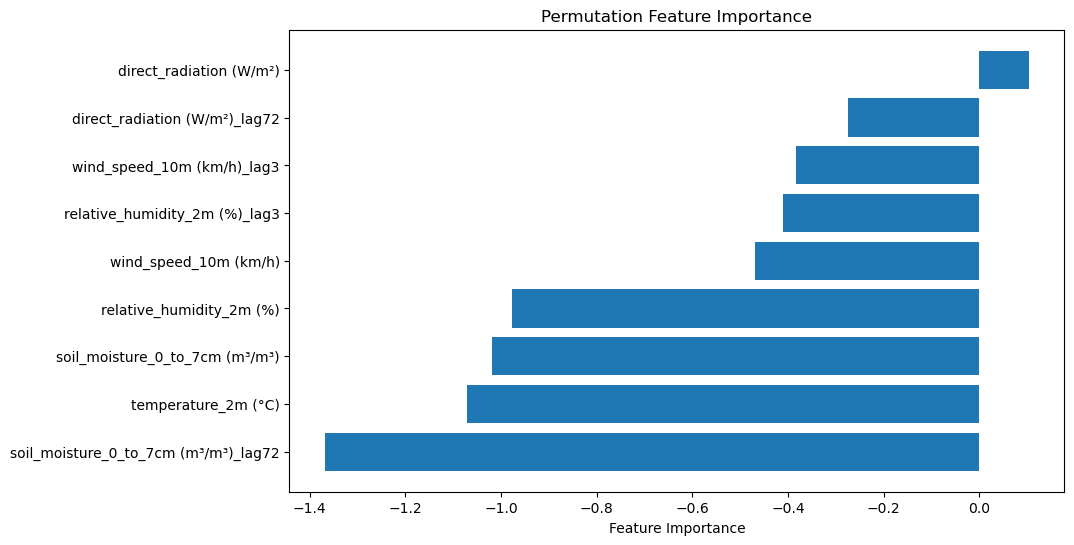

In [81]:
# Feature importance using permutation importance
from sklearn.inspection import permutation_importance

# Fit your KNN model
best_knn.fit(X_train, y_train)

# Get permutation importance (on validation set)
result = permutation_importance(best_knn, X_val, y_val, n_repeats=10, random_state=42)

# Extract importance scores
importance = result.importances_mean

# Sort the features by importance
sorted_idx = importance.argsort()

# Plot the feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(range(len(importance)), importance[sorted_idx], align='center')
plt.yticks(range(len(importance)), X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Permutation Feature Importance')
plt.show()
